### Chapter 6
# Decision Trees
Decision Trees are versatile Machine Learning algorithms that can perform both classification and regression tasks, and even multioutput tasks. They are very powerful algorithms, capable of fitting complex datasets.

Decision Trees are also the fundamental components of Random Forests.

# Training and Visualizing a Decision Tree
Let’s just build one and take a look at how it makes predictions. The following code trains a DecisionTreeClassifier on the iris dataset:

In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

You can visualize the trained Decision Tree by first using the export_graphviz() method to output a graph definition file called iris_tree.dot:

In [3]:
from sklearn.tree import export_graphviz

def image_path(fig_id):
    return os.path.join(IMAGES_PATH, fig_id)

export_graphviz(
        tree_clf,
        out_file=image_path("iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

<img src="images\decision_trees\iris_tree.png" alt="Alt text describing the image">

# Making Prediction
- A node’s samples attribute counts how many training instances it applies to. For example, 100 training instances have a petal length greater than 2.45 cm (depth 1, right), among which 54 have a petal width smaller than 1.75 cm (depth 2, left).
- A node’s value attribute tells you how many training instances of each class this node applies to: for example, the bottom-right node applies to 0 Iris-Setosa, 1 IrisVersicolor, and 45 Iris-Virginica.
- A node’s gini attribute measures its impurity: a node is “pure” (gini=0) if all training instances it applies to belong to the same class. Equation shows how the training algorithm computes the gini score $G_i$ of the ith node. For example, the depth-2 left node has a gini score equal to $ 1 – (0/54)^2 – (49/54)^2 – (5/54)^2 ≈ 0.168. $ 

*Gini impurity*
$$ G_i = 1 - \sum_{k=1}^{1}P_{i,k}^2 $$

The thick vertical line represents the decision boundary of the root node (depth 0): petal length = 2.45 cm. Since the left area is pure (only Iris-Setosa), the right area is impure, so the depth-1 right node splits it at petal width = 1.75 cm. Since max_depth was set to 2, the Decision Tree stops right there.

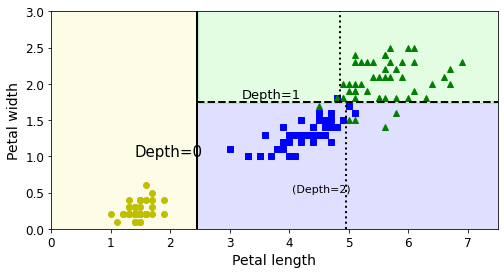

In [9]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

plt.show()

# Estimating Class Probabilities
First it traverses the tree to find the leaf node for this instance, and then it returns the ratio of training instances of class k in this node. Suppose you have found a flower whose petals are 5 cm long and 1.5 cm wide. The corresponding leaf node is the depth-2 left node, so the Decision Tree should output the following probabilities: 0% for Iris-Setosa (0/54), 90.7% for Iris-Versicolor (49/54), and 9.3% for Iris-Virginica (5/54). Let’s check this:

In [5]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [6]:
tree_clf.predict([[5, 1.5]])

array([1])

# Regularization Hyperparameters
Decision Trees do not make many assumptions about the training data, unlike linear models. If a Decision Tree is unconstrained, it may overfit the data by fitting it too closely. This is known as a nonparametric model because the number of parameters is not predetermined, allowing the model to stick closely to the data. However, to prevent overfitting, you can restrict the Decision Tree's freedom during training using regularization. This can be done by reducing the maximum depth of the tree. The Scikit-Learn library allows you to control this using the max_depth hyperparameter, which, if reduced, can help to regularize the model and reduce the risk of overfitting.

The DecisionTreeClassifier class has a few other parameters that similarly restrict the shape of the Decision Tree: min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_leaf_nodes, and max_features. Increasing min_* hyperparameters or reducing max_* hyperparameters will regularize the model.

On the left, the Decision Tree is trained with the default hyperparameters (i.e., no restrictions), and on the right the Decision Tree is trained with min_samples_leaf=4. It is quite obvious that the model on the left is overfitting

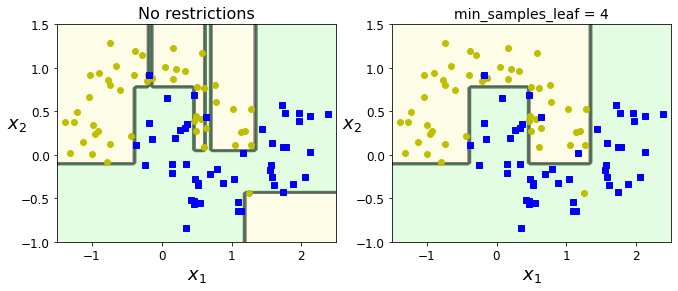

In [7]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

plt.show()

Performs a 2D rotation of the Iris data in the numpy array X by an angle of 20 degrees (converted to radians).

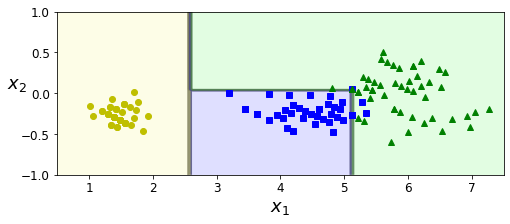

In [10]:
angle = np.pi / 180 * 20
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = X.dot(rotation_matrix)

tree_clf_r = DecisionTreeClassifier(random_state=42)
tree_clf_r.fit(Xr, y)

plt.figure(figsize=(8, 3))
plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -1.0, 1], iris=False)

plt.show()

Generates a plot that shows the sensitivity of a decision tree classifier to the rotation of the training data.

Simple linearly separable dataset: on the left, a Decision Tree can split it easily, while on the right, after the dataset is rotated by 45°, the decision boundary looks unnecessarily convoluted. Although both Decision Trees fit the training set perfectly, it is very
likely that the model on the right will not generalize well. One way to limit this problem is to use PCA, which often results in a better orientation of the training data.

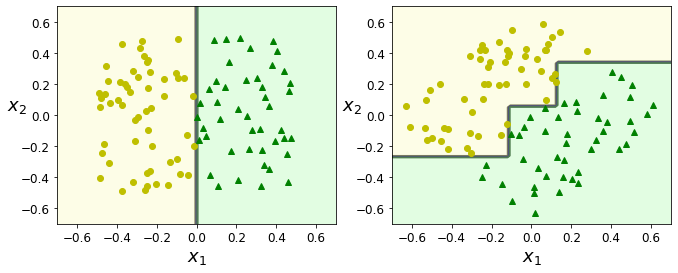

In [11]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)

plt.show()

# Regression
Decision Trees are also capable of performing regression tasks. Let’s build a regression tree using Scikit-Learn’s DecisionTreeRegressor class, training it on a noisy quadratic dataset with max_depth=2:

In [12]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [13]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [14]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [19]:
export_graphviz(
    tree_reg1,
    out_file=image_path("regression_tree.png"),
    feature_names=["x1"],
    rounded=True,
    filled=True
)

# convert the dot file to png
import os
os.system("dot -Tpng regression_tree.dot -o regression_tree.png")

0

The resulting tree is represented:

![image](images\decision_trees\regression_tree.png)

The regression tree is similar to a classification tree but predicts a continuous value instead of a class. The prediction for a new instance is the average target value of the training instances associated with the leaf node that the instance falls into. The model’s predictions are illustrated in a graph and the predicted value for each region is the average target value of the instances in that region. The algorithm splits each region in a way that makes most training instances as close as possible to that predicted value. The max_depth hyperparameter can be used to limit the depth of the tree and simplify the predictions.

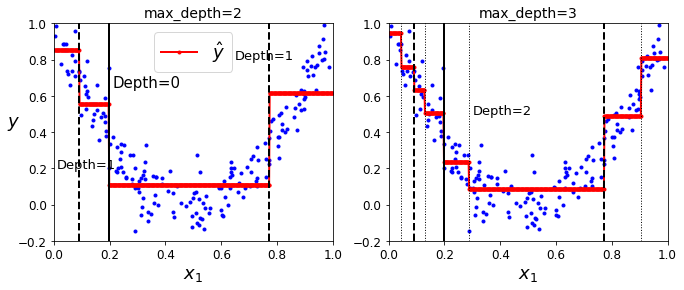

In [20]:
def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

The main difference between CART and the earlier algorithm is that instead of minimizing impurity, CART tries to minimize the Mean Squared Error (MSE).

Just like for classification tasks, Decision Trees are prone to overfitting when dealing with regression tasks. Without any regularization, you get the predictions on the left. It is obviously overfitting the training set very badly. Just setting min_samples_leaf=10 results in a much more reasonable model, represented on the right.

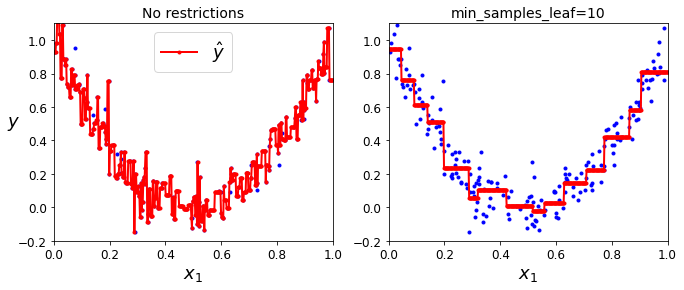

In [21]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.subplot(122)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

plt.show()

Decision Trees are very sensitive to small variations in the training data, which can lead to very different trees being generated for very similar datasets. This is because the algorithm recursively makes decisions based on the data, and small changes can lead to very different decisions being made. This is why it's important to use techniques such as ensemble methods (e.g. Random Forests) to help reduce this sensitivity and improve the robustness of the model.

In [23]:
iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # widest Iris-Versicolor flower

array([[4.8, 1.8]])

In [32]:
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(max_depth=2, random_state=40)

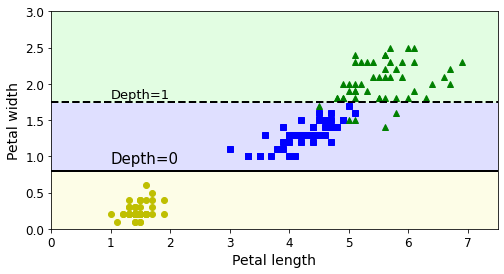

In [33]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

plt.show()